# Beat-Upbeat Ratio Distributions

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats
import statsmodels.formula.api as smf

from src import utils
from src.detect.detect_utils import OnsetMaker
from src.features.features_utils import BeatUpbeatRatio
from src.visualise.bur_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
N_BOOT = 999

In [3]:
# Upper and lower bounds to use when thresholding BURs
BUR_UPPER = 4.0
BUR_LOWER = 0.25

In [4]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Load in data
We start by loading in our onset data. This gives us a list of `OnsetMaker` classes (defined in `src\detect\detect_utils.py`).

In [5]:
onsets: list[OnsetMaker] = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

In [75]:
res = []
# Iterate through each track
for num, track in enumerate(onsets, 1):
    print(f'{num} / {len(onsets)}')
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    # Iterate through each instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        my_onsets = track.ons[instr]
        my_beats = summary_dict[instr]
        # Extract BURs using our feature class
        bm = BeatUpbeatRatio(my_onsets=my_onsets, my_beats=my_beats, clean_outliers=False)
        # Iterate through every log BUR by that musician
        for bur in bm.bur_log['burs'].dropna().values:
            # Append a new dictionary
            res.append(dict(
                mbz_id=track.item['mbz_id'],
                bur=bur,
                instrument=instr,
                tempo=track.tempo,
                bandleader=track.item['pianist']
            ))
burs = pd.DataFrame(res)

1 / 300
2 / 300
3 / 300
4 / 300
5 / 300
6 / 300
7 / 300
8 / 300
9 / 300
10 / 300
11 / 300
12 / 300
13 / 300
14 / 300
15 / 300
16 / 300
17 / 300
18 / 300
19 / 300
20 / 300
21 / 300
22 / 300
23 / 300
24 / 300
25 / 300
26 / 300
27 / 300
28 / 300
29 / 300
30 / 300
31 / 300
32 / 300
33 / 300
34 / 300
35 / 300
36 / 300
37 / 300
38 / 300
39 / 300
40 / 300
41 / 300
42 / 300
43 / 300
44 / 300
45 / 300
46 / 300
47 / 300
48 / 300
49 / 300
50 / 300
51 / 300
52 / 300
53 / 300
54 / 300
55 / 300
56 / 300
57 / 300
58 / 300
59 / 300
60 / 300
61 / 300
62 / 300
63 / 300
64 / 300
65 / 300
66 / 300
67 / 300
68 / 300
69 / 300
70 / 300
71 / 300
72 / 300
73 / 300
74 / 300
75 / 300
76 / 300
77 / 300
78 / 300
79 / 300
80 / 300
81 / 300
82 / 300
83 / 300
84 / 300
85 / 300
86 / 300
87 / 300
88 / 300
89 / 300
90 / 300
91 / 300
92 / 300
93 / 300
94 / 300
95 / 300
96 / 300
97 / 300
98 / 300
99 / 300
100 / 300
101 / 300
102 / 300
103 / 300
104 / 300
105 / 300
106 / 300
107 / 300
108 / 300
109 / 300
110 / 300
111 / 30

Before we do any cleaning, get the total number of beat-upbeat ratios

In [77]:
total_no_clean = burs[burs['instrument'] == 'piano'].shape[0]
print(total_no_clean)

30358


## Clean data
We drop BUR values lower than 0.25 and higher than 4 (see Corcoran & Frieler, 2021)

In [78]:
burs = burs[(burs['bur'] > np.log2(BUR_LOWER)) & (burs['bur'] < np.log2(BUR_UPPER))]

Now we can get the total number of BURs after cleaning

In [80]:
total_after_clean = burs[burs['instrument'] == 'piano'].shape[0]
print(total_after_clean)
print(1 - (total_after_clean / total_no_clean))

30177
0.005962184597140818


We can also get the number of BURs per instrument

In [10]:
burs.groupby('instrument')['bur'].count()

instrument
bass      7362
drums    49100
piano    30177
Name: bur, dtype: int64

In [11]:
np.exp(burs['bur'].mean())

1.79907539940859

In [92]:
burs.groupby('instrument')['bur'].mean()

instrument
bass    -0.006271
drums    0.825607
piano    0.344289
Name: bur, dtype: float64

In [91]:
burs.groupby('instrument')['bur'].mean().apply(np.exp)

instrument
bass     0.993748
drums    2.283266
piano    1.410986
Name: bur, dtype: float64

Now we order our dataframe so that the instruments are in the correct order (piano -> bass -> drums)

In [14]:
burs = (
    burs.set_index('instrument')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

In [90]:
jm = burs[(burs['instrument'] == 'piano')]['bur']
means = [jm.sample(frac=1, replace=True, random_state=i).mean() for i in range(10000)]
print(np.quantile(means, 0.025), np.quantile(means, 0.975))

0.33659698313478215 0.3519003965658446


In [16]:
np.log2(BUR_LOWER)

-2.0

## Plot the average BUR per instrument

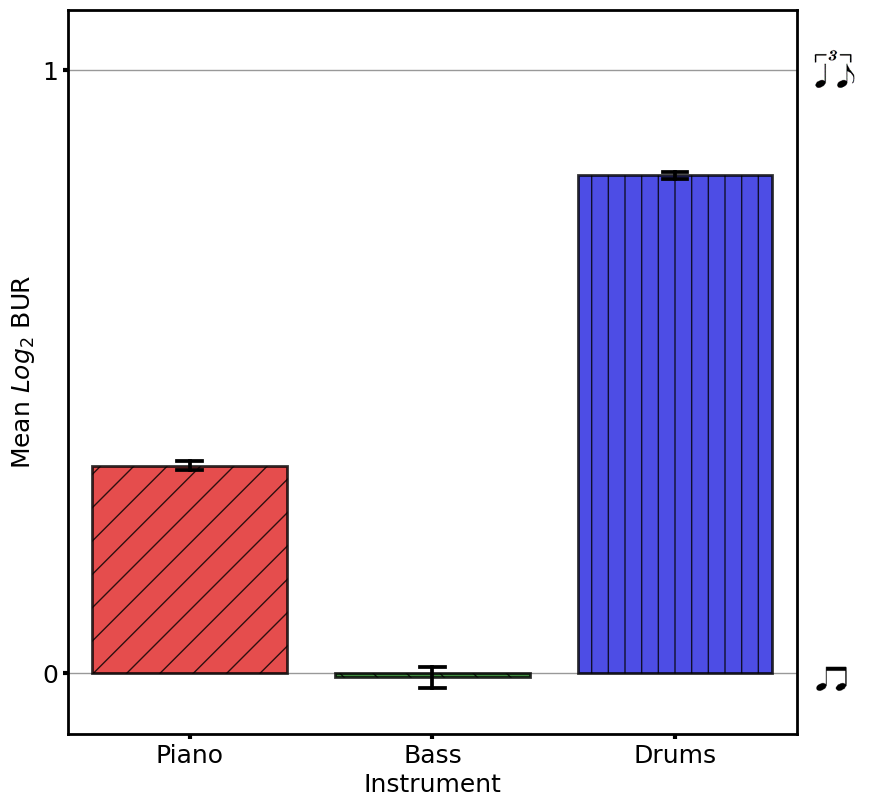

In [17]:
BarPlotBUR(burs).create_plot()
plt.show()

## Plot BUR distribution per performer

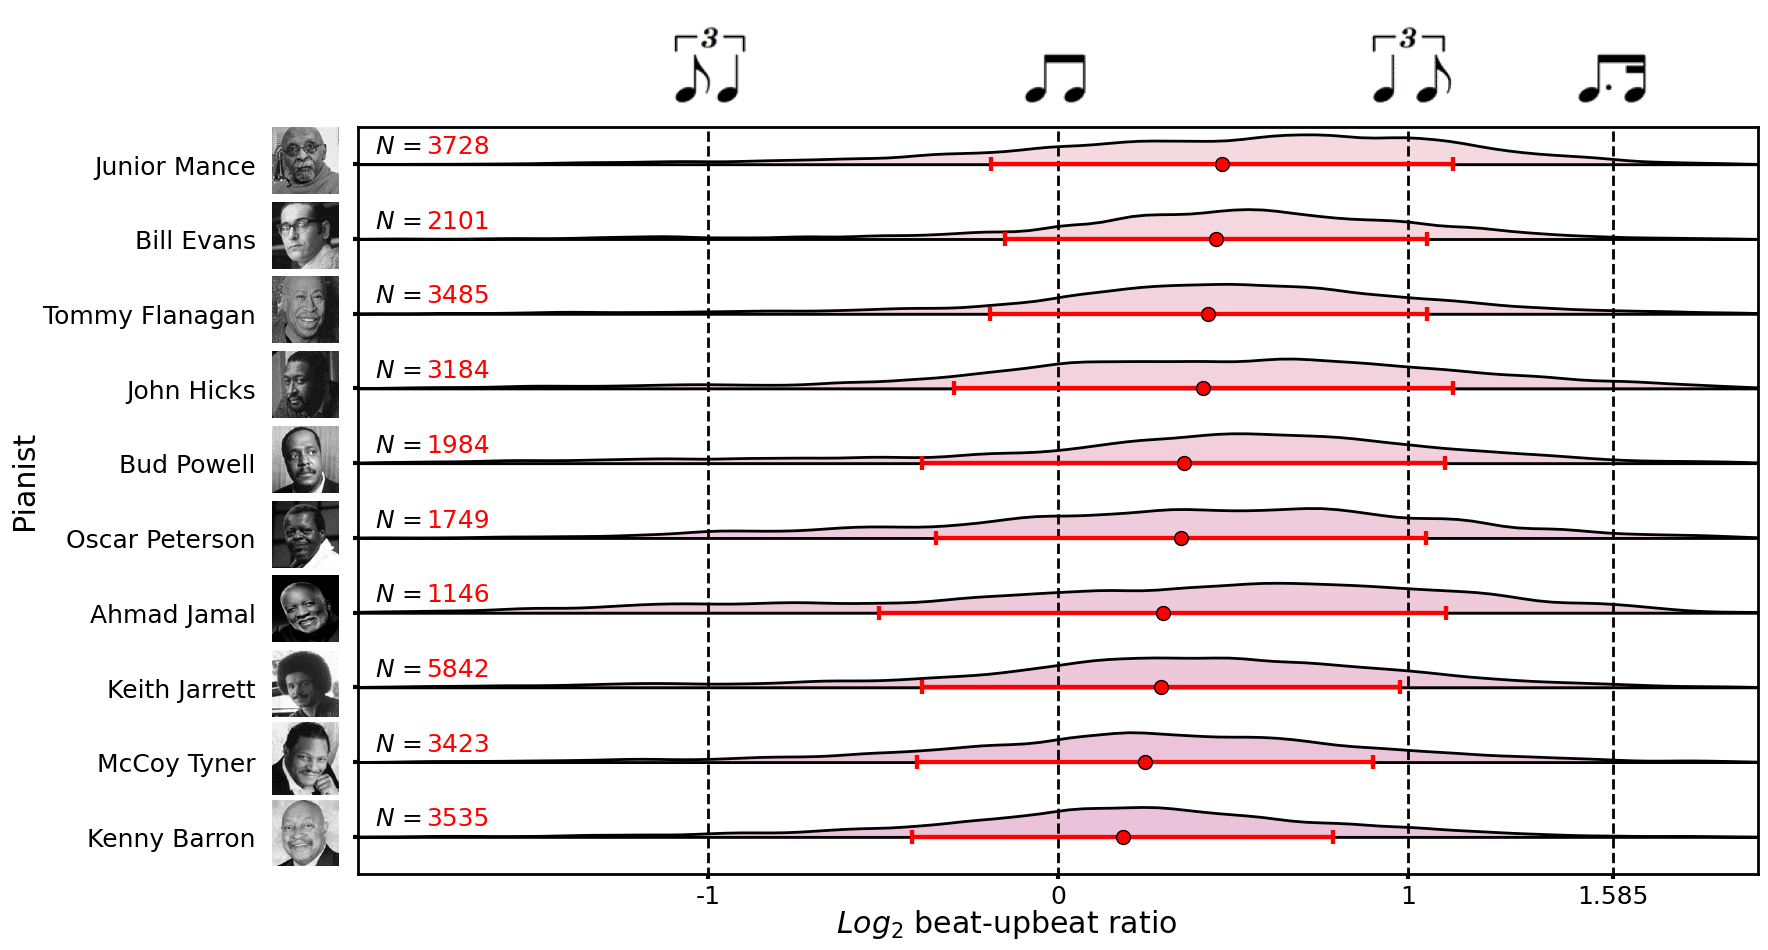

In [67]:
ViolinPlotBURs(burs).create_plot()
plt.show()

## Compute the KDE and extract peaks

In [35]:
def get_peaks(data, len_data: int = 1000, **kwargs) -> np.ndarray:
    """Fits a kernel-density estimate to BUR data and extracts BUR peaks"""
    # Fit the actual KDE to the data, using the default parameters
    kde = stats.gaussian_kde(data.T, bw_method='silverman')
    # Create a linear space of integers ranging from our lowest to our highest BUR
    data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
    # Evaluate the KDE on our linear space of integers
    kde_eval = kde.evaluate(data_plot.T)
    # Find the peaks from our fitted KDE
    peaks, _ = signal.find_peaks(kde_eval, **kwargs)
    # Return the sorted peaks from our KDE: this will be an array of BUR values
    return np.sort(data_plot[peaks].flatten())

In [36]:
def bootstrap_peaks(data: np.array, actual_peaks: np.array, tol: float = 0.5) -> dict:
    """Bootstrap confidence intervals for an array of peaks"""
    # We create a dictionary with lists for storing our bootstrapped peaks
    boot_res = {pe: [] for pe in actual_peaks}
    # We perform a few operations here, so we don't have to re-do them every loop
    size = len(data)
    data = data.flatten()
    # For every bootstrapped sample
    for i_ in range(1):
        print(i_)
        # Set the random seed
        np.random.seed(i_)
        # Take a random sample of our BURs, with replacement, and reshape
        boot = np.random.choice(data, replace=True, size=size).reshape(-1, 1)
        # Get the peaks for our bootstrapped sample
        boot_peaks = set(get_peaks(boot))
        # Iterate through the actual peaks of our BURs
        for peak in actual_peaks:
            # Try and find the closest value in our bootstrapped set
            try:
                closest_peak = min(boot_peaks, key=lambda x: abs(x - peak))
            # If we've run out of bootstrapped peaks, break out and finish this sample early
            except ValueError:
                break
            else:
                # If the distance between our actual peak and the nearest bootstrapped peak exceeds our threshold
                if abs(closest_peak - peak) > tol:
                    # Then continue on to the next actual peak, without matching
                    continue
                else:
                    # Otherwise, match our actual peak with this closest peak and remove it from the set
                    boot_res[peak].append(closest_peak)
                    boot_peaks.remove(closest_peak)
    # Return a dictionary with
    return {k: [np.nanpercentile(v, 5), np.nanpercentile(v, 95)] for k, v in boot_res.items()}

In [37]:
res_ = []
for instr, grp in burs.groupby('instrument', sort=False):
    X = grp['bur'].to_numpy().reshape(-1, 1)
    grp_peaks = get_peaks(X)
    ci_peaks = bootstrap_peaks(X, grp_peaks)
    for num, (actual, (low, high)) in enumerate(ci_peaks.items()):
        res_.append(dict(
            instrument=instr,
            peak_num=num,
            peak=actual,
            low=low,
            high=high
        ))
peaks_df = pd.DataFrame(res_)

0
0
0


In [38]:
peaks_df['raw_peak'] = 2 ** peaks_df['peak']
peaks_df

,instrument,peak_num,peak,low,high,raw_peak
0,piano,0,0.352431,0.446515,0.446515,1.276710
1,bass,0,-0.030300,-0.024688,-0.024688,0.979216
2,bass,1,0.934852,0.837693,0.837693,1.911695
3,drums,0,1.175175,1.167167,1.167167,2.258203


## Estimate density of distribution between peaks

In [21]:
def estimate_density(peaks, burs):
    # Peak 1
    p1 = burs[burs <= (peaks[1] + peaks[0]) / 2]
    p1_len = (len(p1) / len(burs)) * 100
    # Peak 2
    p2 = burs[burs > (peaks[1] + peaks[0]) / 2]
    p2_len = (len(p2) / len(burs)) * 100
    return p1_len, p2_len


bass_peaks = peaks_df[peaks_df['instrument'] == 'bass']['peak'].sort_values().values
bass_weight = estimate_density(
    bass_peaks,
    burs[burs['instrument'] == 'bass']['bur']
)
print(bass_weight)
# drums_peaks = peaks_df[peaks_df['instrument'] == 'drums']['peak'].sort_values().values
# drums_weight = estimate_density(
#     drums_peaks,
#     burs[burs['instrument'] == 'drums']['bur']
# )
# print(drums_weight)

(72.4123879380603, 27.587612061939694)


In [59]:
bandleaders = pd.Series(burs['bandleader'].unique())
bandleaders_sample = [bandleaders.sample(replace=True, frac=1) for i in range(1000)]
for instr, instr_peaks in zip(['bass'], [bass_peaks]):
    boot_low, boot_high = [], []
    for n, sample in enumerate(bandleaders_sample):
        print(n)
        data = []
        for _, bandleader in sample.items():
            data.extend(burs[(burs['bandleader'] == bandleader) & (burs['instrument'] == instr)]['bur'].to_list())
        low, high = estimate_density(instr_peaks, pd.Series(data),)
        boot_low.append(low)
        boot_high.append(high)
    print(instr, 'low_peak', stats.sem(boot_low) * 1.96)
    print(instr, 'high_peak', stats.sem(boot_high) * 1.96)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Plot the BUR distribution with density curve and peaks

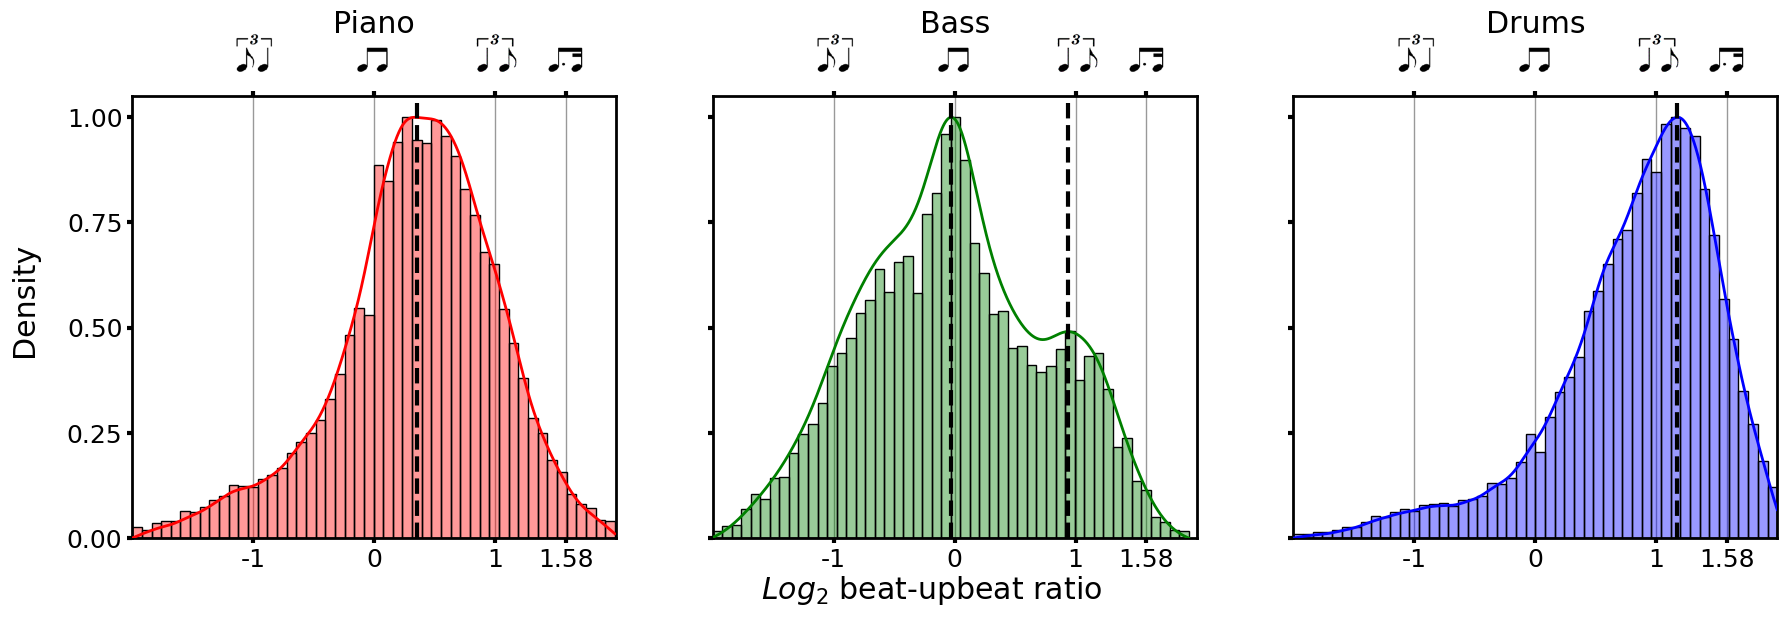

In [39]:
HistPlotBURByInstrument(burs, peaks_df).create_plot()
plt.show()

## Model average tempo vs BUR

In [41]:
average = burs.groupby(['instrument', 'mbz_id']).agg(dict(bur=['mean', 'count'], tempo='median', bandleader='first')).reset_index(drop=False)
average.columns = ['_'.join(col).strip() for col in average.columns.values]
print(len(average[average['bur_count'] < 15]))
average = average[average['bur_count'] > 15]


136


In [43]:
average['tempo_standard'] = (average['tempo_median'] - average['tempo_median'].mean()) / average['tempo_median'].std()

In [25]:
print(average['tempo_median'].mean())
print(average['tempo_median'].std())

191.65171353871168
49.87805590123291


In [48]:
md = smf.mixedlm(
    "bur_mean ~ tempo_standard * C(instrument_, Treatment(reference='piano'))",
    data=average,
    groups=average['bandleader_first'],
    re_formula="0 + tempo_standard + C(instrument_, Treatment(reference='piano'))"
).fit()
print(md.summary())

                                                         Mixed Linear Model Regression Results
Model:                                              MixedLM                                 Dependent Variable:                                 bur_mean
No. Observations:                                   704                                     Method:                                             REML    
No. Groups:                                         10                                      Scale:                                              0.0547  
Min. group size:                                    64                                      Log-Likelihood:                                     -8.4944 
Max. group size:                                    75                                      Converged:                                          Yes     
Mean group size:                                    70.4                                                                                    

In [27]:
(md.params['tempo_standard'] / average['tempo_median'].std()) * 10

-0.022764618133512684

In [28]:
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.to_numpy().mean())
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

conditional_r2: 0.6841665775473703
marginal_r2: 0.6767007096533229


In [29]:
stddev = np.std([v.iloc[0] for v in md.random_effects.values()])
print('stdev of bandleader groups:', stddev)

stdev of bandleader groups: 0.05192293662980194


## Plot average BUR vs tempo

0
1
2
3
4
5
6
7
8
9


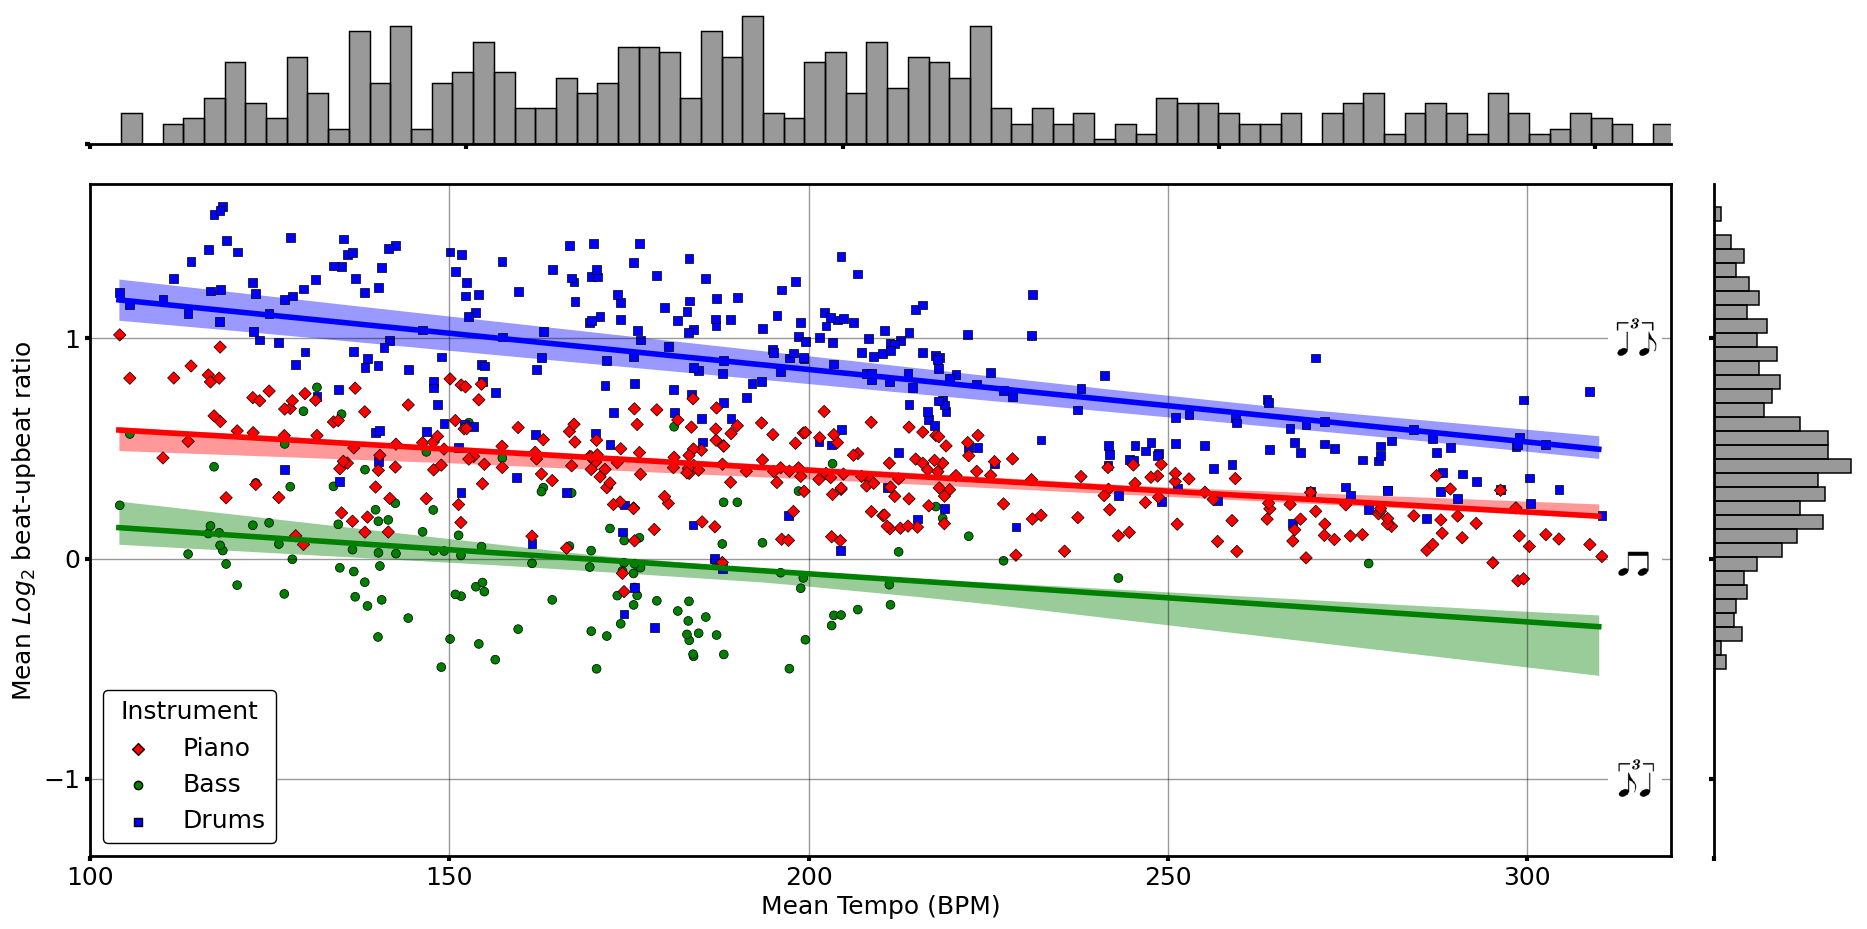

In [30]:
RegPlotBURTempo(burs).create_plot()
plt.show()